In [6]:
from simpletransformers.seq2seq import Seq2SeqModel
import datasets
import torch

import re
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/mt/eng_-french.csv')

In [3]:
df['English words/sentences'] = df['English words/sentences'].apply(lambda x: re.sub(r"[^a-zA-Z0-9]+", ' ', x))
df['English words/sentences'] = df['English words/sentences'].apply(lambda x: x.strip())

df['French words/sentences'] = df['French words/sentences'].apply(lambda x: re.sub(r"[^a-zA-Z0-9]+", ' ', x))
df['French words/sentences'] = df['French words/sentences'].apply(lambda x: x.strip())
df.columns = ['input_text', 'target_text']

In [4]:
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=2020)
eval_df, test_df = train_test_split(eval_df, test_size=0.5, random_state=2020)
metric = datasets.load_metric('bleu')

In [7]:
train_params = {
    'max_seq_length': 100,
    'train_batch_size': 16,
    'eval_batch_size': 16,
    'num_train_epochs': 2,
    'evaluate_during_training': True,
    'evaluate_generated_text': True,
    'use_multiprocessing': False,
    'use_multiprocessing_for_evaluation': False,
    'fp16': False,
    'save_steps': -1,
    'save_eval_checkpoints': False,
    'save_model_every_epoch': False,
    'no_cache': True,
    'reprocess_input_data': True,
    'overwrite_output_dir': True,
    'preprocess_inputs': False,
    'num_return_sequences': 1,
}

In [9]:
model = Seq2SeqModel(
    encoder_decoder_type='marian',
    encoder_decoder_name='Helsinki-NLP/opus-mt-en-ROMANCE',
    use_cuda=torch.cuda.is_available(),
    args=train_params
)

In [10]:
train_history = model.train_model(train_df, eval_data=eval_df)

/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:3221: FutureWarning: `prepare_seq2seq_batch` is deprecated and will be removed in version 5 of 🤗 Transformers. Use the regular `__call__` method to prepare your inputs and the tokenizer under the `with_target_tokenizer` context manager to prepare your targets. See the documentation of your specific tokenizer for more details
  warnings.warn(


/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


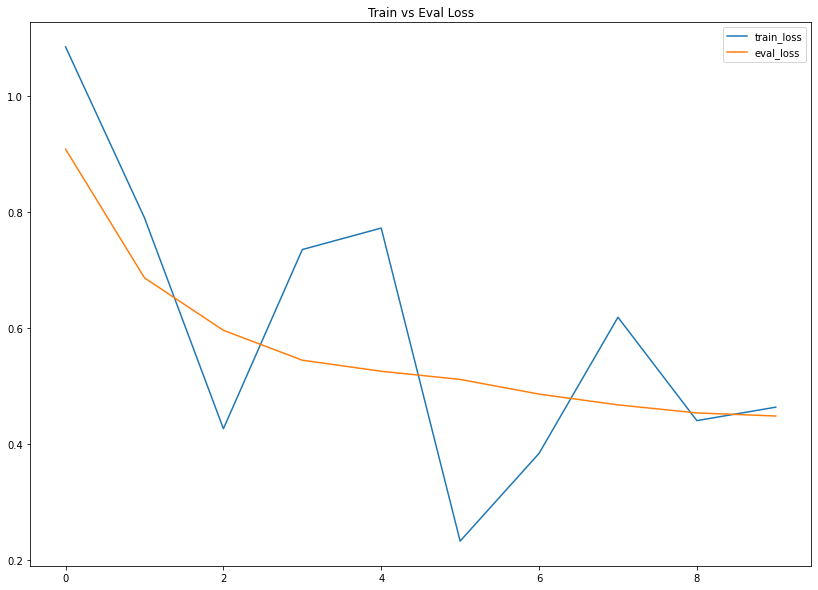

In [11]:
plt.figure(figsize=(14, 10))
plt.title('Train vs Eval Loss')
plt.plot(train_history[1]['train_loss'], label='train_loss')
plt.plot(train_history[1]['eval_loss'], label='eval_loss')

plt.legend()

# Evaluation

In [12]:
predictions = model.predict(test_df['input_text'].tolist())

In [13]:
def compute_bleu(gts, preds):    
    references = []
    for text in gts:
        references.append([text.split()])

    predictions = []
    for text in preds:
        predictions.append(text.split())

    return metric.compute(predictions=predictions, references=references)

In [14]:
compute_bleu(test_df['target_text'].tolist(), predictions)

{'bleu': 0.4030543765444134,
 'precisions': [0.6608567898761227,
  0.4984202752535874,
  0.38617017508648066,
  0.30515387467556543],
 'brevity_penalty': 0.9080577566733685,
 'length_ratio': 0.9120365435858394,
 'translation_length': 119796,
 'reference_length': 131350}